# Notebook pour projet DCD

## Roadmap

1 - Import all metrics in an array of shape *metrics* × *species* × *values*

2 - Cluster *species* × *values* for each metric then compare to orthologs

3 - Analyse the repartition of values

In [2]:
import sklearn.cluster
import matplotlib.pyplot as plt
import numpy
import pandas
import glob
import plotly.express as px
import copy

## 1 - Import

In [3]:
#Run
arraylist = list()
metrics_list = glob.glob("metrics/*.tsv")
for filename in metrics_list:
    csv_df = pandas.read_csv(filename, delimiter = "\t", index_col=0)
    arraylist.append(csv_df)

In [4]:
#Run
np_list = list()
for array in arraylist:
    shape = array.shape
    array_nonacol = array.dropna(axis=0, thresh = shape[1] - 10000)
    array_nona = array_nonacol.dropna(axis = 1)
    np_list.append(array_nona)

In [5]:
#Run
# we need all rows and columns names that are not common to all the arrays
columns = set(np_list[0].columns)
rows = set(np_list[0].index)
cols_todel = list()
rows_todel = list()

for array in np_list: # first get all common elements
    rows = rows.intersection(set(array.index))
    columns = columns.intersection(set(array.columns))

for array in np_list: # then get the diff for each array
    rows_todel.append(set(array.index) - rows)
    cols_todel.append(set(array.columns) - columns)

In [6]:
#Run
stackable_arrays = list()
for array, rows, cols in zip(np_list, rows_todel, cols_todel):
    temp = array.drop(index=rows)
    stackable_arrays.append(temp.drop(columns = cols))
array_predict = copy.deepcopy(stackable_arrays) # will serve for the prediction 

In [7]:
stacked_arrays = numpy.stack([i.to_numpy() for i in stackable_arrays])
stacked_arrays.shape

(4, 57, 597)

## 2 - Cluster for each metric then compare to orthologs

### Cluster

In [19]:
# from metrics : species : genes to genes : metrics
to_merge = list()
for i in range(stacked_arrays.shape[1]):
    to_merge.append(stacked_arrays[:,i,:].transpose())
genes_x_metrics = numpy.concatenate(to_merge)
genes_x_metrics.shape

(34029, 4)

In [20]:
sc = sklearn.cluster.OPTICS(min_samples=57).fit(genes_x_metrics)
max(sc.labels_)

34

### Compare

Create a count cluster : labels

In [21]:
labels = list()
for i in range(stacked_arrays.shape[1]):
    labels += list(stackable_arrays[0].columns)

In [22]:
counts_by_labels = dict()
for cluster, label in zip(sc.labels_, labels):
    if cluster not in counts_by_labels:
        counts_by_labels[cluster]=dict()
    if label not in counts_by_labels[cluster]:
        counts_by_labels[cluster][label]=0
    counts_by_labels[cluster][label] += 1

Then graph it as a stacked barplot

In [34]:
data = {"name": list(), "parent": list(), "value": list()}
for cluster in counts_by_labels:
    if not cluster == -1:
        for label in counts_by_labels[cluster]:
            data["name"].append(label)
            data["parent"].append(cluster)
            data["value"].append(counts_by_labels[cluster][label])

In [35]:
# parent is cluster
# character is ortholog
# values is count character by cluster
fig = px.bar(data, x="parent", y="value", color="name", title = "Groupes d'orthologie contenus dans chaque cluster")
fig.show(renderer="browser")

What's the mean gene content for clusters ?

In [32]:
sum_clusters = list()
for i in counts_by_labels:
    if i != -1:
        sum_cluster = 0
        for j in counts_by_labels[i]:
            sum_cluster += counts_by_labels[i][j]
        sum_clusters.append((i, sum_cluster))
sum([i[1] for i in sum_clusters])/len(sum_clusters)

145.45714285714286

Now let's analyse clusters : are they determined more by species or by orthology ? Since we have 57 species and 34 clusters it mays indicate something ; but then each group should contain a unique copy of each ortholog gene.

In [17]:
cluster_content = list()
for cluster in counts_by_labels:
    cluster_content.append((cluster,sum([counts_by_labels[cluster][i] for i in counts_by_labels[cluster]])/len([counts_by_labels[cluster][i] for i in counts_by_labels[cluster]])))
cluster_content

[(-1, 48.553691275167786),
 (26, 1.446808510638298),
 (13, 6.098522167487685),
 (2, 1.2361111111111112),
 (27, 1.4086021505376345),
 (11, 1.6296296296296295),
 (24, 1.6349206349206349),
 (3, 1.6026490066225165),
 (28, 1.2903225806451613),
 (10, 1.1403508771929824),
 (34, 1.9189189189189189),
 (19, 1.2307692307692308),
 (29, 1.353846153846154),
 (14, 1.3235294117647058),
 (15, 1.1904761904761905),
 (8, 1.381679389312977),
 (12, 1.2191780821917808),
 (6, 1.2903225806451613),
 (5, 1.2584269662921348),
 (33, 1.6829268292682926),
 (1, 1.6311475409836065),
 (31, 1.5957446808510638),
 (23, 1.2222222222222223),
 (17, 1.3736263736263736),
 (30, 1.7849462365591398),
 (25, 1.34375),
 (22, 1.1636363636363636),
 (0, 1.368421052631579),
 (18, 1.2266666666666666),
 (32, 1.4482758620689655),
 (20, 1.2463768115942029),
 (7, 1.2424242424242424),
 (4, 1.2253521126760563),
 (9, 1.1694915254237288),
 (16, 1.0923076923076922),
 (21, 1.3243243243243243)]

Average value is ~ 1 ; it confirm our hypothesis that the metrics are determined by species and so the clusters reflect the species. But why do we have the 13th cluster ?

In [19]:
sorted([[i, counts_by_labels[13][i]] for i in counts_by_labels[13]], key = lambda x: x[1])

[['2961', 1],
 ['79886', 1],
 ['56913', 1],
 ['506', 1],
 ['27190', 1],
 ['23234', 1],
 ['8464', 1],
 ['7172', 1],
 ['941', 1],
 ['8813', 1],
 ['25949', 1],
 ['29088', 1],
 ['8883', 1],
 ['94103', 1],
 ['79035', 1],
 ['51026', 1],
 ['84275', 1],
 ['283576', 1],
 ['874', 1],
 ['64757', 1],
 ['286451', 1],
 ['10577', 1],
 ['5129', 1],
 ['6750', 1],
 ['79642', 1],
 ['9113', 1],
 ['843', 1],
 ['80267', 1],
 ['25897', 1],
 ['126767', 1],
 ['11264', 1],
 ['26578', 1],
 ['7389', 1],
 ['83464', 1],
 ['11015', 1],
 ['51637', 1],
 ['890', 1],
 ['58527', 1],
 ['401546', 1],
 ['4548', 1],
 ['8539', 1],
 ['64841', 1],
 ['9470', 1],
 ['51804', 1],
 ['171177', 1],
 ['6697', 1],
 ['1143', 1],
 ['55584', 1],
 ['5648', 1],
 ['6425', 1],
 ['164284', 1],
 ['79768', 1],
 ['53836', 1],
 ['7374', 1],
 ['54757', 1],
 ['91975', 1],
 ['144577', 1],
 ['55180', 1],
 ['92591', 1],
 ['57168', 1],
 ['79689', 1],
 ['55734', 1],
 ['6001', 1],
 ['2302', 1],
 ['60386', 1],
 ['55248', 1],
 ['2643', 1],
 ['55176', 1],
 ['

Two orthologs groups are almost full (57 and 55) ; additionnal info on these genes tell us that they are associated one with immune response and the other with cell cycle. These are essential functions which implies selective pressure and limited evolution.
This may explain that genes cluster together. However, we need to check if other genes in other clusters have a similar profile.

## Is evolution at the origin of the previous clustering ?

In [16]:
#TODO prévoir une analyse d'alignements pour vérifier que les gènes du cluster 16 sont bien moins conservés que ceux du cluster 13

### Compare GC3 / GC

Compare clustering using rates at the 3rd position of the codon (synonymous pos, not selected) with clustering using rates for the gene.

In [36]:
conserved = pandas.read_csv("metrics/metrics_GC3_exons.tsv", delimiter = "\t", index_col=0)
random = pandas.read_csv("metrics_GC_gene.tsv", delimiter = "\t", index_col = 0)

In [37]:
np_list = list()
for array in conserved, random:
    shape = array.shape
    array_nonacol = array.dropna(axis=0, thresh = shape[1] - 10000)
    array_nona = array_nonacol.dropna(axis = 1)
    np_list.append(array_nona)

In [38]:
# we need all rows and columns names that are not common to all the arrays
columns = set(np_list[0].columns)
rows = set(np_list[0].index)
cols_todel = list()
rows_todel = list()

for array in np_list: # first get all common elements
    common_species = rows.intersection(set(array.index))
    common_genes = columns.intersection(set(array.columns))

for array in np_list: # then get the diff for each array
    rows_todel.append(set(array.index) - common_species)
    cols_todel.append(set(array.columns) - common_genes)

In [39]:
stackable_arrays = list()
for array, rows, cols in zip(np_list, rows_todel, cols_todel):
    temp = array.drop(index=rows)
    stackable_arrays.append(temp.drop(columns = cols))

In [40]:
stacked_arrays = numpy.stack([i.to_numpy() for i in stackable_arrays])
stacked_arrays.shape

(2, 57, 659)

In [41]:
to_merge = list()
for i in range(stacked_arrays.shape[1]):
    to_merge.append(stacked_arrays[0,i,:].transpose().reshape(-1, 1))
genes_x_gc = numpy.concatenate(to_merge)
genes_x_gc.shape

(37563, 1)

In [42]:
to_merge = list()
for i in range(stacked_arrays.shape[1]):
    to_merge.append(stacked_arrays[1,i,:].transpose().reshape(-1, 1))
genes_x_gc3 = numpy.concatenate(to_merge)
genes_x_gc3.shape

(37563, 1)

In [43]:
sc = sklearn.cluster.OPTICS(min_samples=57, metric="euclidean").fit(genes_x_gc)
cluster_conserved = list(sc.labels_)
cluster_conserved

[-1,
 -1,
 -1,
 12,
 -1,
 -1,
 44,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 19,
 -1,
 -1,
 -1,
 11,
 -1,
 -1,
 -1,
 -1,
 -1,
 59,
 67,
 -1,
 -1,
 -1,
 -1,
 40,
 -1,
 -1,
 -1,
 -1,
 17,
 7,
 -1,
 17,
 -1,
 -1,
 10,
 -1,
 -1,
 -1,
 -1,
 -1,
 72,
 14,
 31,
 -1,
 -1,
 -1,
 13,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 10,
 50,
 7,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 25,
 -1,
 -1,
 -1,
 11,
 10,
 31,
 -1,
 -1,
 -1,
 -1,
 -1,
 19,
 -1,
 -1,
 -1,
 -1,
 -1,
 23,
 -1,
 -1,
 -1,
 -1,
 -1,
 13,
 -1,
 60,
 -1,
 72,
 34,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 50,
 -1,
 -1,
 -1,
 -1,
 51,
 24,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 45,
 -1,
 -1,
 -1,
 -1,
 17,
 40,
 -1,
 11,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 42,
 -1,
 -1,
 -1,
 -1,
 63,
 -1,
 -1,
 -1,
 -1,
 -1,
 26,
 -1,
 -1,
 -1,
 -1,
 12,
 -1,
 31,
 -1,
 7,
 -1,
 -1,
 -1,
 12,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1

In [44]:
sc = sklearn.cluster.OPTICS(min_samples=57).fit(genes_x_gc3)
cluster_random = list(sc.labels_)
cluster_random

[-1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 23,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 21,
 -1,
 -1,
 -1,
 -1,
 -1,
 32,
 -1,
 -1,
 -1,
 -1,
 -1,
 30,
 -1,
 -1,
 -1,
 -1,
 53,
 -1,
 -1,
 -1,
 66,
 70,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 6,
 28,
 -1,
 26,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 14,
 -1,
 -1,
 36,
 -1,
 40,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 30,
 -1,
 -1,
 -1,
 46,
 25,
 34,
 -1,
 -1,
 14,
 -1,
 23,
 -1,
 -1,
 -1,
 -1,
 20,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 70,
 46,
 71,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 10,
 -1,
 -1,
 72,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 26,
 -1,
 -1,
 68,
 13,
 -1,
 -1,
 5,
 18,
 24,
 -1,
 -1,
 -1,
 72,
 38,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 38,
 -1,
 -1,
 -1,
 -1,
 -1,
 -

Let's analyse these new clusters to see how they correlate with our previous clustering. First, let's make a count of genes by clusters.

In [45]:
labels = list()
for i in range(stacked_arrays.shape[1]):
    labels += list(stackable_arrays[0].columns)

In [46]:
gc_by_labels = dict()
for cluster, label in zip(cluster_conserved, labels):
    if cluster not in gc_by_labels:
        gc_by_labels[cluster]=dict()
    if label not in gc_by_labels[cluster]:
        gc_by_labels[cluster][label] = 0
    gc_by_labels[cluster][label] += 1

In [47]:
gc3_by_labels = dict()
for cluster, label in zip(cluster_random, labels):
    if cluster not in gc3_by_labels:
        gc3_by_labels[cluster]=dict()
    if label not in gc3_by_labels[cluster]:
        gc3_by_labels[cluster][label] = 0
    gc3_by_labels[cluster][label] += 1

In [48]:
data = {"name": list(), "parent": list(), "value": list()}
for cluster in gc_by_labels:
    if not cluster == -1:
        for label in gc_by_labels[cluster]:
            data["name"].append(label)
            data["parent"].append(cluster)
            data["value"].append(gc_by_labels[cluster][label])
fig = px.bar(data, x="parent", y="value", color="name", title = "Groupes d'orthologies contenus dans chaque cluster pour le taux de GC")
fig.show(renderer="browser")

In [50]:
data = {"name": list(), "parent": list(), "value": list()}
for cluster in gc3_by_labels:
    if not cluster == -1:
        for label in gc3_by_labels[cluster]:
            data["name"].append(label)
            data["parent"].append(cluster)
            data["value"].append(gc3_by_labels[cluster][label])
fig = px.bar(data, x="parent", y="value", color="name", title = "Groupes d'orthologies contenus dans chaque cluster pour le taux de GC3")
fig.show(renderer="browser")

How much genes by orthologs groups are in clusters ?

In [57]:
cluster_content_gc = list()
for cluster in gc_by_labels:
    cluster_content_gc.append((cluster,sum([gc_by_labels[cluster][i] for i in gc_by_labels[cluster]])/len([gc_by_labels[cluster][i] for i in gc_by_labels[cluster]])))
cluster_content_gc

[(-1, 40.5402124430956),
 (12, 2.293598233995585),
 (44, 1.118279569892473),
 (19, 1.1458333333333333),
 (11, 1.0686274509803921),
 (59, 1.634703196347032),
 (67, 1.3766233766233766),
 (40, 1.3225806451612903),
 (17, 1.4559386973180077),
 (7, 1.297029702970297),
 (10, 1.1864406779661016),
 (72, 1.275),
 (14, 1.150943396226415),
 (31, 1.8581818181818182),
 (13, 1.0655737704918034),
 (50, 1.336283185840708),
 (25, 1.3773584905660377),
 (23, 1.3035714285714286),
 (60, 1.2333333333333334),
 (34, 1.1142857142857143),
 (51, 1.2359550561797752),
 (24, 1.121212121212121),
 (45, 1.1634615384615385),
 (42, 1.3377483443708609),
 (63, 1.103896103896104),
 (26, 1.3085106382978724),
 (61, 1.1643835616438356),
 (5, 1.1647058823529413),
 (15, 1.108910891089109),
 (64, 1.1379310344827587),
 (21, 1.3144654088050314),
 (41, 1.1886792452830188),
 (37, 1.095890410958904),
 (6, 1.2017543859649122),
 (18, 1.1063829787234043),
 (35, 1.110091743119266),
 (4, 1.2706766917293233),
 (20, 1.170940170940171),
 (3, 

In [58]:
cluster_content_gc3 = list()
for cluster in gc3_by_labels:
    cluster_content_gc3.append((cluster,sum([gc3_by_labels[cluster][i] for i in gc3_by_labels[cluster]])/len([gc3_by_labels[cluster][i] for i in gc3_by_labels[cluster]])))
cluster_content_gc3

[(-1, 44.23823975720789),
 (23, 1.284263959390863),
 (21, 1.1696428571428572),
 (32, 1.1578947368421053),
 (30, 1.5896414342629481),
 (53, 1.1372549019607843),
 (66, 1.5041322314049588),
 (70, 2.2941176470588234),
 (6, 1.3055555555555556),
 (28, 1.1981132075471699),
 (26, 1.2117647058823529),
 (14, 1.3439490445859872),
 (36, 1.1710526315789473),
 (40, 1.1868131868131868),
 (46, 1.19),
 (25, 1.2459016393442623),
 (34, 1.2882882882882882),
 (20, 1.2782608695652173),
 (71, 1.7419354838709677),
 (10, 1.1454545454545455),
 (72, 1.4545454545454546),
 (68, 1.3246753246753247),
 (13, 1.1875),
 (5, 1.2345679012345678),
 (18, 1.1170212765957446),
 (24, 1.1170212765957446),
 (38, 1.1884057971014492),
 (49, 1.5561497326203209),
 (57, 1.2307692307692308),
 (22, 1.2913385826771653),
 (63, 1.3737373737373737),
 (27, 1.1926605504587156),
 (31, 1.4871794871794872),
 (9, 1.3109243697478992),
 (51, 1.2318840579710144),
 (54, 1.2641509433962264),
 (35, 1.1388888888888888),
 (56, 1.1176470588235294),
 (37,

Compare the two clusterings with the previous one.

In [59]:
match_clusters = list()
for i in counts_by_labels:
    temp = list()
    for j in gc3_by_labels:
        size_intersect = len(set(counts_by_labels[i]).intersection(set(gc3_by_labels[j])))
        relative = size_intersect / sum([counts_by_labels[i][k] for k in counts_by_labels[i]]) *100
        temp.append((relative, i, j))
    match_clusters.append(sorted(temp, reverse=True)[0])
match_clusters

[(2.059575644481305, -1, -1),
 (69.11764705882352, 26, -1),
 (16.397415185783522, 13, -1),
 (80.89887640449437, 2, -1),
 (70.99236641221374, 27, -1),
 (61.36363636363637, 11, -1),
 (61.165048543689316, 24, -1),
 (62.396694214876035, 3, -1),
 (77.5, 28, -1),
 (87.6923076923077, 10, -1),
 (52.112676056338024, 34, -1),
 (81.25, 19, -1),
 (73.86363636363636, 29, -1),
 (75.55555555555556, 14, -1),
 (84.0, 15, -1),
 (72.37569060773481, 8, -1),
 (82.02247191011236, 12, -1),
 (77.5, 6, -1),
 (79.46428571428571, 5, -1),
 (59.42028985507246, 33, -1),
 (61.30653266331658, 1, -1),
 (62.66666666666667, 31, -1),
 (81.81818181818183, 23, -1),
 (72.8, 17, -1),
 (56.024096385542165, 30, -1),
 (74.4186046511628, 25, -1),
 (85.9375, 22, -1),
 (73.07692307692307, 0, -1),
 (81.52173913043478, 18, -1),
 (69.04761904761905, 32, -1),
 (80.23255813953489, 20, -1),
 (80.48780487804879, 7, -1),
 (81.60919540229885, 4, -1),
 (85.5072463768116, 9, -1),
 (91.54929577464789, 16, -1),
 (75.51020408163265, 21, -1)]

In [60]:
match_clusters = list()
for i in counts_by_labels:
    temp = list()
    for j in gc_by_labels:
        size_intersect = len(set(counts_by_labels[i]).intersection(set(gc_by_labels[j])))
        relative = size_intersect / sum([counts_by_labels[i][k] for k in counts_by_labels[i]]) *100
        temp.append((relative, i, j))
    match_clusters.append(sorted(temp, reverse=True)[0])
match_clusters

[(2.059575644481305, -1, -1),
 (69.11764705882352, 26, -1),
 (16.397415185783522, 13, -1),
 (80.89887640449437, 2, -1),
 (70.99236641221374, 27, -1),
 (61.36363636363637, 11, -1),
 (61.165048543689316, 24, -1),
 (62.396694214876035, 3, -1),
 (77.5, 28, -1),
 (87.6923076923077, 10, -1),
 (52.112676056338024, 34, -1),
 (81.25, 19, -1),
 (73.86363636363636, 29, -1),
 (75.55555555555556, 14, -1),
 (84.0, 15, -1),
 (72.37569060773481, 8, -1),
 (82.02247191011236, 12, -1),
 (77.5, 6, -1),
 (79.46428571428571, 5, -1),
 (59.42028985507246, 33, -1),
 (61.30653266331658, 1, -1),
 (62.66666666666667, 31, -1),
 (81.81818181818183, 23, -1),
 (72.8, 17, -1),
 (56.024096385542165, 30, -1),
 (74.4186046511628, 25, -1),
 (85.9375, 22, -1),
 (73.07692307692307, 0, -1),
 (81.52173913043478, 18, -1),
 (69.04761904761905, 32, -1),
 (80.23255813953489, 20, -1),
 (80.48780487804879, 7, -1),
 (81.60919540229885, 4, -1),
 (85.5072463768116, 9, -1),
 (91.54929577464789, 16, -1),
 (75.51020408163265, 21, -1)]

Max numbers of hits for a given clustering is always in the noise cluster in the other clustering. That suggests that we should vary clustering parameters.

In [61]:
min_noise = (100000000000000, []) # very high number to ensure that we'll get better
for i in numpy.arange(57, 100, step=10):
    sc = sklearn.cluster.OPTICS(min_samples=57).fit(genes_x_gc)
    cluster_conserved = list(sc.labels_)
    print(len([j for j in cluster_conserved if j == -1]))
    if min_noise[0] > len([j for j in cluster_conserved if j == -1]):
        min_noise = (len([j for j in cluster_conserved if j == -1]), i, cluster_conserved)
min_noise

26571
26571
26571
26571
26571


(26571,
 57,
 [-1,
  -1,
  -1,
  12,
  -1,
  -1,
  45,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  19,
  -1,
  -1,
  -1,
  11,
  -1,
  -1,
  37,
  -1,
  -1,
  60,
  68,
  -1,
  -1,
  -1,
  -1,
  41,
  -1,
  -1,
  -1,
  -1,
  17,
  7,
  -1,
  17,
  -1,
  -1,
  10,
  -1,
  -1,
  -1,
  -1,
  -1,
  73,
  14,
  31,
  -1,
  -1,
  -1,
  13,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  10,
  51,
  7,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  25,
  -1,
  -1,
  -1,
  11,
  10,
  31,
  -1,
  -1,
  -1,
  -1,
  -1,
  19,
  -1,
  -1,
  -1,
  -1,
  -1,
  23,
  -1,
  -1,
  -1,
  -1,
  -1,
  13,
  -1,
  61,
  -1,
  73,
  34,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  51,
  -1,
  -1,
  -1,
  -1,
  52,
  24,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  46,
  -1,
  -1,
  -1,
  -1,
  17,
  41,
  -1,
  11,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,

Let's create a species vector to match orthologs with their species of origin.

In [63]:
labels_species = list()
for i in common_species:
    count = 0
    while(count < stacked_arrays.shape[2]):
        labels_species.append(str(i))
        count += 1
len(labels_species)

37563

In [64]:
df = pandas.DataFrame({"cluster":cluster_conserved, "genes_x_gc":[i[0] for i in genes_x_gc.tolist()], "species":labels_species})
fig = px.scatter(df, y="cluster", x="genes_x_gc", color = "species", title = "Cluster et espèce pour chaque gène en fonction du taux de GC, méthode OPTICS")
fig.show(renderer="browser")

In [65]:
data = sklearn.cluster.KMeans(n_clusters=57).fit(genes_x_gc)
df = pandas.DataFrame({"cluster":data.labels_, "genes_x_gc":[i[0] for i in genes_x_gc.tolist()], "species":labels_species})
fig = px.scatter(df, y="cluster", x="genes_x_gc", color="species", title = "Cluster et espèce pour chaque gène en fonction du taux de GC, méthode KMeans")
fig.show(renderer="browser")

Is there a cluster associated strongly with a particular species ?

In [76]:
species_by_cluster_km = dict() # dict of cluster : species : count
sum_by_cluster = dict()
for i, j in zip(data.labels_, labels_species):
    if i not in species_by_cluster_km:
        species_by_cluster_km[i] = dict()
        sum_by_cluster[i] = 0
    if j not in species_by_cluster_km[i]:
        species_by_cluster_km[i][j] = 0
    species_by_cluster_km[i][j] += 1
    sum_by_cluster[i] += 1
species_by_cluster_km

{25: {'9601': 23,
  '9986': 8,
  '51338': 9,
  '42254': 13,
  '30608': 14,
  '9233': 14,
  '9749': 11,
  '29078': 22,
  '9238': 33,
  '419612': 18,
  '10141': 18,
  '27679': 14,
  '10020': 21,
  '132908': 10,
  '37293': 7,
  '38654': 13,
  '10160': 19,
  '176946': 19,
  '10036': 17,
  '61621': 16,
  '125878': 17,
  '61622': 21,
  '9785': 25,
  '9531': 20,
  '10047': 16,
  '591936': 19,
  '28737': 15,
  '1868482': 7,
  '9793': 19,
  '79684': 15,
  '10181': 27,
  '9796': 20,
  '9031': 15,
  '9544': 20,
  '9798': 17,
  '30538': 9,
  '35019': 13,
  '885580': 22,
  '9555': 13,
  '9685': 30,
  '336983': 21,
  '13146': 11,
  '188379': 21,
  '9691': 18,
  '482537': 14,
  '10090': 19,
  '8954': 14,
  '9708': 17,
  '10093': 22,
  '185453': 18,
  '55661': 24,
  '9713': 21,
  '1737458': 16,
  '48883': 20,
  '9978': 16,
  '9598': 12,
  '181119': 13},
 42: {'9601': 23,
  '9986': 23,
  '51338': 23,
  '42254': 18,
  '30608': 16,
  '9233': 21,
  '9749': 22,
  '29078': 19,
  '9238': 28,
  '419612': 26,


In [77]:
percent = dict()
for i in species_by_cluster_km:
    percent[i] = dict()
    for j in species_by_cluster_km[i]:
        percent[i][j] = species_by_cluster_km[i][j] / sum_by_cluster[i] * 100
percent

{25: {'9601': 2.3565573770491803,
  '9986': 0.819672131147541,
  '51338': 0.9221311475409836,
  '42254': 1.331967213114754,
  '30608': 1.4344262295081966,
  '9233': 1.4344262295081966,
  '9749': 1.1270491803278688,
  '29078': 2.2540983606557377,
  '9238': 3.3811475409836067,
  '419612': 1.8442622950819672,
  '10141': 1.8442622950819672,
  '27679': 1.4344262295081966,
  '10020': 2.151639344262295,
  '132908': 1.0245901639344261,
  '37293': 0.7172131147540983,
  '38654': 1.331967213114754,
  '10160': 1.9467213114754098,
  '176946': 1.9467213114754098,
  '10036': 1.7418032786885245,
  '61621': 1.639344262295082,
  '125878': 1.7418032786885245,
  '61622': 2.151639344262295,
  '9785': 2.5614754098360657,
  '9531': 2.0491803278688523,
  '10047': 1.639344262295082,
  '591936': 1.9467213114754098,
  '28737': 1.5368852459016393,
  '1868482': 0.7172131147540983,
  '9793': 1.9467213114754098,
  '79684': 1.5368852459016393,
  '10181': 2.7663934426229506,
  '9796': 2.0491803278688523,
  '9031': 1.5

In [88]:
top_km = list()
for i in percent:
    top_km.append((max([percent[i][j] for j in percent[i]]), i))
sorted(top_km)

[(2.5306122448979593, 5),
 (2.537182852143482, 42),
 (2.5962399283795885, 22),
 (2.6455026455026456, 21),
 (2.684563758389262, 53),
 (2.7358490566037736, 1),
 (2.782931354359926, 24),
 (2.804642166344294, 55),
 (2.8241335044929397, 18),
 (2.841530054644809, 27),
 (2.8604118993135015, 2),
 (2.910360884749709, 7),
 (2.9382957884427032, 12),
 (2.953020134228188, 37),
 (3.009259259259259, 0),
 (3.058103975535168, 50),
 (3.0627871362940278, 14),
 (3.0756442227763925, 46),
 (3.096539162112933, 49),
 (3.107658157602664, 45),
 (3.131991051454139, 11),
 (3.2175032175032174, 28),
 (3.2225579053373616, 13),
 (3.290246768507638, 54),
 (3.307607497243661, 35),
 (3.3296337402885685, 48),
 (3.3811475409836067, 25),
 (3.389830508474576, 26),
 (3.4482758620689653, 41),
 (3.4988713318284423, 8),
 (3.5443037974683547, 32),
 (3.5476718403547673, 19),
 (3.7037037037037033, 47),
 (3.7467700258397936, 38),
 (3.8194444444444446, 51),
 (3.8461538461538463, 33),
 (3.867403314917127, 4),
 (3.870967741935484, 29)

In [96]:
species_by_cluster_km[20]

{'9601': 1,
 '51338': 1,
 '9749': 1,
 '132908': 1,
 '38654': 1,
 '176946': 1,
 '10036': 2,
 '61621': 2,
 '1868482': 8,
 '10093': 1,
 '185453': 1,
 '181119': 1}

In [90]:
species_by_cluster_optics = dict() # dict of cluster : species : count
sum_by_cluster = dict()
for i, j in zip(cluster_conserved, labels_species):
    if i not in species_by_cluster_optics:
        species_by_cluster_optics[i] = dict()
        sum_by_cluster[i] = 0
    if j not in species_by_cluster_optics[i]:
        species_by_cluster_optics[i][j] = 0
    species_by_cluster_optics[i][j] += 1
    sum_by_cluster[i] += 1
percent = dict()
for i in species_by_cluster_optics:
    percent[i] = dict()
    for j in species_by_cluster_optics[i]:
        percent[i][j] = species_by_cluster_optics[i][j] / sum_by_cluster[i] * 100
top_opt = list()
for i in percent:
    top_opt.append((max([percent[i][j] for j in percent[i]]), i))
sorted(top_opt)

[(1.8441157653080427, -1),
 (3.2723772858517806, 12),
 (3.289473684210526, 22),
 (3.326810176125244, 31),
 (3.35195530726257, 60),
 (3.4246575342465753, 25),
 (3.4653465346534658, 43),
 (3.7037037037037033, 42),
 (3.829787234042553, 56),
 (3.896103896103896, 39),
 (3.9473684210526314, 17),
 (4.046242774566474, 9),
 (4.046242774566474, 32),
 (4.098360655737705, 14),
 (4.166666666666666, 37),
 (4.198473282442748, 7),
 (4.301075268817205, 47),
 (4.464285714285714, 15),
 (4.471544715447155, 26),
 (4.519774011299435, 40),
 (4.545454545454546, 48),
 (4.587155963302752, 11),
 (4.615384615384616, 13),
 (4.6875, 69),
 (4.716981132075472, 68),
 (4.733727810650888, 4),
 (4.784688995215311, 21),
 (4.794520547945205, 23),
 (4.807692307692308, 18),
 (4.807692307692308, 45),
 (4.878048780487805, 41),
 (4.938271604938271, 63),
 (4.958677685950414, 35),
 (4.958677685950414, 46),
 (5.0, 50),
 (5.072463768115942, 1),
 (5.109489051094891, 20),
 (5.263157894736842, 70),
 (5.298013245033113, 51),
 (5.298013

In [101]:
max([(species_by_cluster_optics[73][i], i) for i in species_by_cluster_optics[73]])

(10, '1868482')

# Prédiction

Nous allons utiliser des techniques d'apprentissage supervisé pour obtenir un pipeline réutilisable permettant de déterminer l'appartenance d'un gène à nos différents groupes d'orthologues.

## Importation des modules pythons

In [ ]:
# traitement de données
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
np.set_printoptions(threshold=10000,suppress=True)
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Comparaison metriques 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
from sklearn.datasets import make_classification
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

# Classifiers

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold
import time

# Pipeline et sortie
from sklearn.pipeline import Pipeline
import pickle

## Transformation des données pour l'apprentissage

In [7]:
# Run
group_tab = numpy.zeros((1,57,597)) # création d'une variable groupe d'orthologie pour le changement de dimension
for j in range(0,57):
    for i in range(0,597):
        group_tab[0][j][i] = i
#array_predict.append(group_tab)        
array_predict = numpy.stack([i.to_numpy() for i in array_predict])

array_predict = numpy.append(array_predict,group_tab, axis=0 ) # ajout de la variable groupe au jeu de données


to_merge = list() # passage d'une tableau 3D à un tableau 2D
for i in range(array_predict.shape[1]):
    to_merge.append(array_predict[:,i,:].transpose())
genes_x_metrics_pred = numpy.concatenate(to_merge) 

X = genes_x_metrics_pred[:,0:6]
labels = genes_x_metrics_pred[:, 6]

(7, 57, 597)


Dans cette étape nous avons créer une métrique groupe qui associe à chaque gène un numéro représentant le groupe d'orthologie auquel il appartient qui servira de label pour l'apprentissage. 

Nous avons ensuite redimensionner notre jeu de données de telle sorte qu'il soit exploitable par les classifieurs

## Mise en place de la comparaison des classifieurs

In [ ]:
# Dictionnaire des classifieurs à tester
clfs = {
'RF': RandomForestClassifier(n_estimators=50, random_state=1),
'KNN': KNeighborsClassifier(n_neighbors=10),
'BAG' : BaggingClassifier(n_estimators = 50, random_state =1),
'ADA': AdaBoostClassifier(n_estimators = 50, random_state =1),
'MLP': MLPClassifier(hidden_layer_sizes= (50,20), alpha = 0.001, max_iter = 100, random_state =1),
'NB': GaussianNB()

}

In [8]:
# Fonctions de comparaison

## Comparaison StratifiedKFold

def run_classifiers(X, labels, modeles):
    """
    Run l'ensemble des classifiers contenus dans modeles, les compare et les trie suivant leur accuracy
    arguments: 
        X(np array): jeu de données contenant uniquement les métriques
        labels(np array): status du jeu de données
        modeles(dic): ensemble des classifieurs à comparer
    retourne: liste_classee liste de tuple (classifieur, accuracy) classé par accuracy
        
    """
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    liste_classee = []
    for mod in modeles:
        begin = time.time()
        modele = modeles[mod]
        cv_acc = cross_val_score(modele, X, labels, cv = kf)
        end = time.time()
        print("Accuracy for {} is : {} +/- {} (in {} seconds)".format(mod,np.mean(cv_acc), np.std(cv_acc), end - begin))
        print()
        liste_classee.append((mod ,np.mean(cv_acc)))
    liste_classee.sort(key=lambda tup: tup[1], reverse= True)
    return liste_classee


## Comparaison toutes transformations de données

def run_classifiers_all_forms(X, labels, modeles):
    """
    Traite les données et les fait tourner sur l'ensemble des classifieurs. 
    arguments: 
        X(np array): jeu de données contenant uniquement les métriques
        labels(np array): status du jeu de données
        modeles(dic): ensemble des classifieurs à comparer
    print: les meilleurs tuples (modele,accuracy) de change traitement de données
        
    """
    
    # non traité
    print("Non traité")
    print()
    base_list = run_classifiers(X, labels, clfs)
    
    # MM Scaler 
    print("MinMax Scaler")
    print()
    MM_scaler = MinMaxScaler()
    MM_scaler.fit(X)
    X_norm_MM = MM_scaler.transform(X)
    MM_list = run_classifiers(X_norm_MM, labels, modeles)
    

    # Standard Scaler
    print("Standard Scaler")
    print()
    Standard_scaler = StandardScaler()
    Standard_scaler.fit(X)
    X_norm_Stand = Standard_scaler.transform(X)
    SS_list = run_classifiers(X_norm_Stand, labels, modeles)


    # PCA 
    print("PCA ")
    print()
    nb_variable = X.shape[1]
    pca = PCA(n_components = nb_variable)
    pca.fit(X_norm_Stand)
    X_pca = pca.transform(X_norm_Stand)
    PCA_list = run_classifiers(X_pca, labels, modeles)
    
    print("meilleure accu base {} pour modele {}".format(base_list[0][1], base_list[0][0]))
    print("meilleure accu MM_norm {} pour modele {}".format(MM_list[0][1], MM_list[0][0]))
    print("meilleure accu SS_norm {} pour modele {}".format(SS_list[0][1], SS_list[0][0]))
    print("meilleure accu PCA {} pour modele {}".format(PCA_list[0][1], PCA_list[0][0]))



In [14]:
# Run comparaison
run_classifiers_all_forms(X, labels, clfs)

Non traité

Accuracy for RF is : 0.2573981016192071 +/- 0.004081049800201967 (in 142.23041009902954 seconds)

Accuracy for KNN is : 0.037761908960004704 +/- 0.0007246071295623133 (in 2.2557625770568848 seconds)

Accuracy for BAG is : 0.2549002321549267 +/- 0.003211362610449483 (in 321.4402494430542 seconds)

Accuracy for ADA is : 0.008816009873931059 +/- 0.0008175631222335977 (in 128.2970471382141 seconds)



/home/sophiane/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy for MLP is : 0.010226571453760028 +/- 0.001301668258858626 (in 258.14132595062256 seconds)

Accuracy for NB is : 0.09065796820359107 +/- 0.0029655824882407044 (in 1.7954750061035156 seconds)

MinMax Scaler

Accuracy for RF is : 0.2578389021129037 +/- 0.00342981938945404 (in 132.98586678504944 seconds)

Accuracy for KNN is : 0.1726468600311499 +/- 0.0018229230855177421 (in 3.2009894847869873 seconds)

Accuracy for BAG is : 0.25584060654147933 +/- 0.003678153708804816 (in 322.8975360393524 seconds)

Accuracy for ADA is : 0.008816009873931059 +/- 0.0008175631222335977 (in 126.53260159492493 seconds)



/home/sophiane/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sophiane/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sophiane/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy for MLP is : 0.09712304211114049 +/- 0.0028651655335240216 (in 443.3206694126129 seconds)

Accuracy for NB is : 0.09206852978342002 +/- 0.0037928200844343733 (in 1.9216954708099365 seconds)

Standard Scaler

Accuracy for RF is : 0.2571336213229892 +/- 0.004103839707391364 (in 156.29193091392517 seconds)

Accuracy for KNN is : 0.1846660201592759 +/- 0.0016101122609306967 (in 3.818899393081665 seconds)

Accuracy for BAG is : 0.254606365159129 +/- 0.003373971943408926 (in 380.4059295654297 seconds)

Accuracy for ADA is : 0.008816009873931059 +/- 0.0008175631222335977 (in 158.66318035125732 seconds)



/home/sophiane/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sophiane/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sophiane/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy for MLP is : 0.15607276146815952 +/- 0.0028804962249476215 (in 537.2722430229187 seconds)

Accuracy for NB is : 0.0920097563842605 +/- 0.0038403368341864592 (in 2.144418716430664 seconds)

PCA 

Accuracy for RF is : 0.22809956213817628 +/- 0.0005773570397128471 (in 153.1108648777008 seconds)

Accuracy for KNN is : 0.1846660201592759 +/- 0.0016101122609306967 (in 3.307884931564331 seconds)

Accuracy for BAG is : 0.22759998824532016 +/- 0.0025996850397715467 (in 380.2391765117645 seconds)

Accuracy for ADA is : 0.005730406418055188 +/- 0.0006478417727540805 (in 146.976243019104 seconds)



/home/sophiane/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sophiane/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sophiane/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy for MLP is : 0.1508713156425402 +/- 0.0014932376521099647 (in 376.43567061424255 seconds)

Accuracy for NB is : 0.1131975667812748 +/- 0.0022174791477755414 (in 1.7050116062164307 seconds)

meilleure accu base 0.2573981016192071 pour modele RF
meilleure accu MM_norm 0.2578389021129037 pour modele RF
meilleure accu SS_norm 0.2571336213229892 pour modele RF
meilleure accu PCA 0.22809956213817628 pour modele RF


## Résultats

 Nous avons décidé de n'étudiais que l'accuracy comme critère de qualité. Aussi nous obtenons ce tableau :

| Méthode/métriques  | Non traitré | MinMax Scaler | Standard Scaler   |    PCA     |
| :------------------|:-----------:|:-------------:|:-----------------:|:----------:|
| RF   |   0.2573   |  **0.2578**   |  0.2571    |  0.2280   |
| KNN  |   0.0377   |  0.1726    |  0.1846    |  0.1846   |
| BAG  |   0.2549   |  0.2558    |  0.2546    |  0.2275   |
| ADA  |   0.0088   |  0.0088    |  0.0088    |  0.0057   |
| MLP  |   0.0102   |  0.0971    |  0.1560    |  0.1508   |
| NB   |   0.0906   |  0.0920    |  0.0920    |  0.1131   |

Comme nous l'observons la meilleure méthode est le RandomForest avec une accuracy moyenne de 25.78%, sur un jeu de données normalisé par la méthode MinMax scaler.

## Optimisation

In [ ]:
# Creation jeu de données test

X_train, X_test, labels_train, labels_test = train_test_split(X, labels, train_size = 0.5, random_state =1)

In [9]:

# Normalisation des données de test

MM_scaler = MinMaxScaler()
MM_scaler.fit(X_train)
X_norm_MM_train = MM_scaler.transform(X_train)
X_norm_MM_test = MM_scaler.transform(X_test)

# Entrainement du meilleur classifieur

clf = RandomForestClassifier(n_estimators=50, random_state=1)
clf.fit(X_norm_MM_train, labels_train)

# Estimation de l'importance des métrique 
importances=clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
sorted_idx = np.argsort(importances)[::-1]


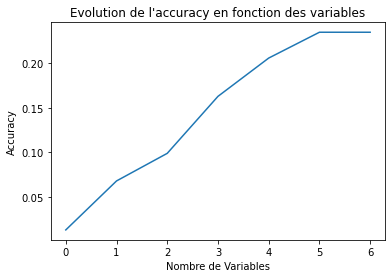

In [16]:
# Observation de l'importance des différentes métriques

scores=np.zeros(X_norm_MM_train.shape[1]+1)
for f in np.arange(0, X_norm_MM_train.shape[1]+1):
    X1_f = X_norm_MM_train[:,sorted_idx[:f+1]]
    X2_f = X_norm_MM_test[:,sorted_idx[:f+1]]
    clf.fit(X1_f,labels_train)
    Yclf=clf.predict(X2_f)
    scores[f]=np.round(accuracy_score(labels_test,Yclf),3)
plt.plot(scores)
plt.xlabel("Nombre de Variables")
plt.ylabel("Accuracy")
plt.title("Evolution de l'accuracy en fonction des variables")
plt.show()

### Reduction de l'espace d'apprentissage

Un risque avec l'apprentissage automatique c'est que nous sur-entrainons notre méthode. En effet, en lui donnant des métriques de faible qualité d'apprentissage nous risquons d'augmenter le bruit et donc de diminuer la qualité de notre méthode. C'est pourquoi il est important d'étudier les métriques utilisées pour ne garder que celles apportant de l'information.

### Résultats 

Comme nous l'obervons dans le plot ci dessus il y a une chute puis stagnation de l'information à partir de la 5eme  variables/métrique ce qui indique que celles après ont un risque d'apporté du bruit. Aussi nous garderons 5 variables pour la suite.

In [ ]:
# Run
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

listparam = [50,100, 200, 300, 400, 500]


criterion_p = ["gini", "entropy"]
class_w = ["balanced", "balanced_subsample"]


param_grid=dict(n_estimators=listparam, class_weight=class_w, criterion=criterion_p)
grid = GridSearchCV(RandomForestClassifier(), param_grid,cv=3, scoring='accuracy')
grid.fit(X_norm_MM_train[: ,sorted_idx[:5]],labels_train)



print(grid.best_params_)
print(grid.best_score_)

### Recherche des meilleurs paramètres

Une fois l'espace des métriques réduit il faut chercher à optimiser notre classifieur à ce qu'il soit le plus juste possible pour notre jeu de donnée. 

Malheureusement cette étape n'a pu être réalisé à causes de limites matérielles ( RAM insuffisante)

## Pipeline final

In [ ]:
#Pipeline

from sklearn.pipeline import Pipeline
import pickle

# Création et pickling du meilleur pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), ('classifier', RandomForestClassifier(n_estimators=100, random_state=1)) ])
pipe.fit(X[: ,sorted_idx[:5]], labels)
pickle.dump(pipe, open("pipeline.pkl", "wb")) # Pickling de notre classifieur entrainé



### Pickling

Le pickling est un moyen de sauvegarder notre modèle optimisé de façon à ce que celui-ci puisse être réutilisé par les autres.

Malheureusement comme à l'étape précédente nous avons été limité matériellement par notre RAM et nous n'avons pu faire cette étape

In [ ]:
# Commande pour appeler le pickle

# Load et utilisation du meilleurs pipeline depuis un pickle
P1=pickle.load(open( "pipeline.pkl", "rb" ) ) 
P1.score(X_test[: ,sorted_idx[:8]], labels_test)
P1.predict_proba(X_test[: ,sorted_idx[:8]])  